<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

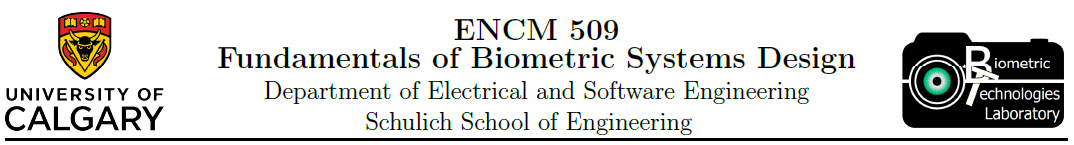

<center>
    <h1>Laboratory Experiment #5</h1>
    <h3>Fingerprint Biometrics - Part II: Matching</h3>
</center>

In [44]:
import skimage
import os
import math
print('The scikit-skimage version is {}.'.format(skimage.__version__))

The scikit-skimage version is 0.18.3.


In [45]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import ndimage as ndi

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, plase open you Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

# custom functions
from utils.blockproc import blockproc

In [48]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [47]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

### Introduction



**PART II: Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (1 mark): Use the demo file `Lab05Fingerprint2gab.ipynb` to perform the Gabor filtering on your fingerprint image, while adjusting the parameters `frequency` and `angle` of the filter. Choose two different values for each of those parameters, one at a time, and visually evaluate the results. What is the impact of  changing the parameters of the Gabor filtering results (visually)? Draw the conclusions.

Text(0.5, 1.0, 'Original Image')

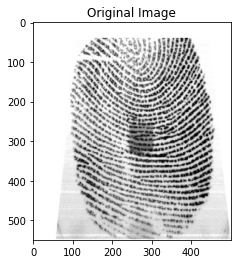

In [33]:
# Pick good and bad quality fingerprints and display images 

path = os.getcwd() + '/Data/'
img = imread(path + 'Jess/8.bmp', as_gray=True)
plt.imshow(img);
plt.title("Original Image")

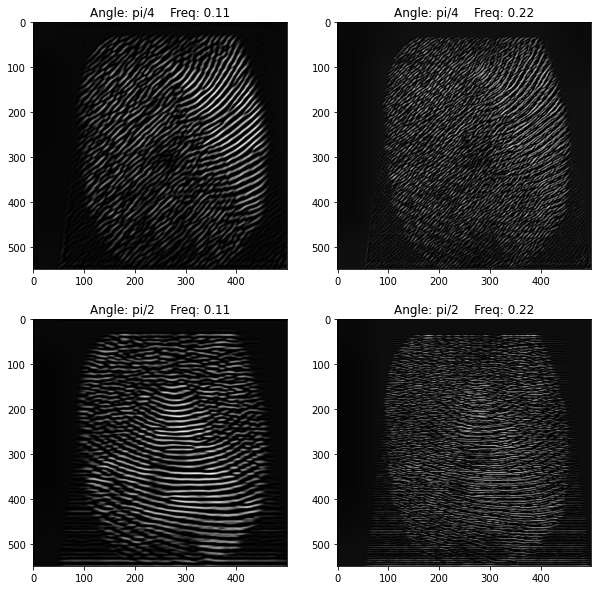

In [39]:
angles = [np.pi/4, np.pi/2]
angle_text = ["pi/4", "pi/2"]
freqs = [0.11, 0.22]
i=1

plt.figure(figsize=(10,10))

for a, atxt in zip(angles, angle_text):
    for f in freqs:
        fi = gabor_template(img, a, f)
        img_f = gabor_filtering(img , fi)
        
        plt.subplot(2,2,i)
        plt.imshow(img_f, cmap='gray', aspect='auto')
        plt.title("Angle: " + atxt + "    Freq: " + str(f))
        
        i = i + 1

Increasing the frequency while keeping the angle constant results in more shorter ridges being detected. Increasing the angle while keeping frequnecy constant changes the orientation of the image. In the images that use angle=pi/4 you can see the ridges are positioned diagonally. However in the images that use anlge=pi/2 the ridges are horizontal. Therefore the frequency parameter determines the density of ridges while the angle dentermines the orientation.

- **Exercise 2** (3 marks): Use 9 of your fingerprints as a database, or a gallery. Use the remaining one as a  probe. The database of 9 templates (feature vectors) represents the same "individual".

    Develop a simple identification procedure (use loops that repeat 1 to 1 matching several times), to  match  a probed fingerprint of your finger (e.g. left thumb) against 9 different impressions of the same   finger. Use the Jupyter notebook `Lab04Fingerprint1.ipynb` that performs 1 to 1 matching. 
        
    Record the scores (use a table - see the first Lab on Markdown how to do a table in Jupyter notebooks) for the **minutiae based matching**. Note that for this type of matching, the higher the score the better the match.

    Record the number of matches against the same fingers (True Positives - TP), and the number of mismatches against the same fingers (False Negatives - FN). How the choice of the threshold affects the  matching? Use the numbers or graphs to illustrate your answer.

In [51]:
# parameters for processing
seg_threshold = 0.4
block_size = 16

path = os.getcwd() + '/Data/Jess/'

probe_img = img_as_ubyte(imread(path + '1.bmp', as_gray=True))  # 1.bmp is probe finger
probe = fingerprint_processing(probe_img, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 23
Total of singularities detected: 0


In [ ]:
## TAKES LONG TIME TO RUN !!!!

for i in range(2, 11):  # 2.bmp - 10.bmp are gallary 
    gallery_img = imread(path + str(i) + '.bmp', as_gray=True)
    gallery = fingerprint_processing(gallery_img, block_size=block_size, threshold=seg_threshold)

    imSkeletonAlign, minutiaArrayAlign = align2(probe, gallery)
    gallery['imSkeletonAlign'] = imSkeletonAlign
    gallery['minutiaArrayAlign'] = minutiaArrayAlign
    
    match_threshold = 6
    score = match(probe, gallery, threshold2=match_threshold)
    print('score for minutiae: %.4f\n' % (score))

| Probe Image |  Probe Minutiae | 
|:----:|:----:|
| 1.bmp | 23  |



| Gallery Image  |  Gallery Minutiae  | Matched Minutiae  |  Score  |  Classification |
|:----:|:----:|:----:|:----:|:----:|
| 2.bmp  |    |   |   |   |
| 3.bmp  |    |   |   |   |
| 4.bmp  |    |   |   |   |
| 5.bmp  |    |   |   |   |
| 6.bmp  |    |   |   |   |
| 7.bmp  |    |   |   |   |
| 8.bmp  |    |   |   |   |
| 9.bmp  |    |   |   |   |
| 10.bmp |    |   |   |   |

Add description of excerise

- **Exercise 3** (2 marks): Repeat the same experiment (using the same images) from Exercise 2, but **instead of minutiae based matching, use the method based on the Gabor filter**. Note that the lower the score, the better the match. Again, record the numbers of the True positives and False negatives.
    Compare the results of Gabor score matching with the minutiae based matching. Draw conclusions upon both experiment results.

- **Exercise 4** (4 marks): Use one of your fingerprints (e.g. left thumb) to be used as the  probed one. Use the database with one  impression of the same finger and 10 of some other finger(s). Therefore, you have a database with 11 templates one of which represents the same "individual", and the rest of the templates represent another "individual(s)."
    Develop a ranking identification procedure for minutiae-based matching only. A sample of such procedure is as follows:
    - Record the matching scores for each comparison; use some index corresponding to the fingerprint number. Sort the matching scores: the top score is the maximum score for the Minutia based approach.
    - Do you have a true match?  If your true match is not on top of your ranking, which rank is it?  Use this rank's score as a "thresholding score" that separates a top-ranked group  of the closest matches from the others.
    - Record the number of matches against different fingers as False Positives, and the mismatches as True Negatives. Some False positives may belong to the top ranked group.
    - Draw the conclusions upon your experiment, such as the threshold choice etc.